In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import rioxarray

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [2]:
import geopandas as gpd
from deafrica_tools.spatial import xr_rasterize
serengeti = gpd.read_file('data/serengeti.geojson')
serengeti = serengeti.to_crs('epsg:21036')
serengeti
#mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds_rf)

#mask the rainfall dataset
#ds_rf = ds_rf.where(mask)

# Plot the mask
#mask.plot()

,ID,AREA,PERIMETER,ACRES,HECTARES,NAME,Status,Protection,geometry
0,0,654692200.0,177073.1,0.0,0.0,Lemek,Group Ranch,Buffer,"MULTIPOLYGON (((496436.722 9767480.112, 496433..."


In [3]:
# Open the NetCDF file using xarray
ds = xr.open_dataset('data/Serengeti_tamsat.nc')
ds = ds.sel(time=slice('2015-01', '2022-09'))
#ds

In [4]:
ds.rio.set_spatial_dims('lon','lat',inplace=True)
ds.rio.write_crs('EPSG:4326',inplace=True)
ds = ds.rio.reproject("EPSG:21036")
ds

<xarray.Dataset>
Dimensions:      (x: 136, y: 134, time: 2830)
Coordinates:
  * x            (x) float64 3.872e+05 3.914e+05 ... 9.446e+05 9.487e+05
  * y            (y) float64 1e+07 9.996e+06 9.992e+06 ... 9.451e+06 9.447e+06
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2022-09-30
    spatial_ref  int64 0
Data variables:
    rfe          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    rfe_filled   (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
Attributes:
    Conventions:  CF-1.6
    CreatedBy:    EDAL Libraries
    MoreInfo:     https://github.com/Reading-eScience-Centre/edal-java

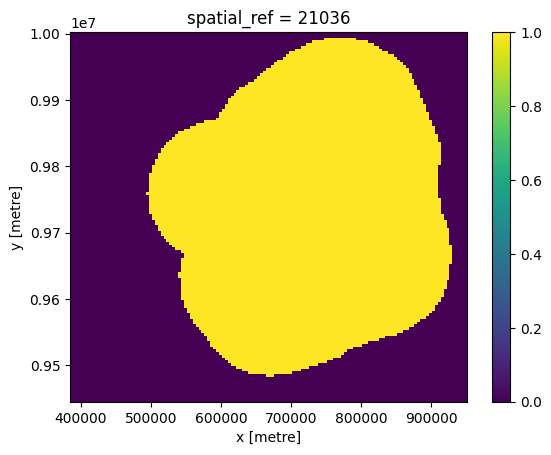

In [5]:
mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds)

#mask the rainfall dataset
ds = ds.where(mask)

# Plot the mask
mask.plot()

In [ ]:
ds.rfe.sel(time=slice('2016-11-20', '2016-12-01')).plot(col='time', col_wrap=5, add_colorbar=False )

In [6]:
# Define the threshold value
threshold = 0.0

# Find the time, latitude, and longitude when rainfall is above the threshold
ds_masked = ds['rfe'].where(ds['rfe'] > threshold, drop=True)
ds_masked

<xarray.DataArray 'rfe' (time: 2690, y: 102, x: 104)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 4.995e+05 5.037e+05 5.079e+05 ... 9.238e+05 9.279e+05
  * y        (y) float64 9.992e+06 9.988e+06 9.984e+06 ... 9.51e+06 9.505e+06
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2022-09-30
Attributes:
    units:          mm
    standard_name:  Rainfall Estimate
    long_name:      Rainfall Estimate

In [7]:
file = "data/Serengeti_all.csv"
dfa = pd.read_csv(file, dtype=None)

dfa['time1'] = pd.to_datetime(dfa['t1_'])
dfa['date1'] = pd.to_datetime(dfa['time1'].dt.date)
dfa['time2'] = pd.to_datetime(dfa['t2_'])
dfa['date2'] = pd.to_datetime(dfa['time2'].dt.date)

# Subset the DataFrame by the date range
dfa.set_index('date1', inplace=True)
dfa = dfa.sort_index()
#df = df['2013-11-11':'2013-11-16']

In [ ]:
dfa.head()

In [ ]:
from matplotlib.patches import FancyArrowPatch

dfs = dfa['2016-11-20':'2016-12-01']
dm = ds_masked.sel(time=slice('2016-11-20', '2016-12-01'))
dm.plot(col='time', col_wrap=3 )

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
unique_ids = dfs['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        gps_data_subset = dfs.loc[dfs.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color=color, label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color=color, s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        
        # Set the x and y axis limits for zooming
        #ax.set_xlim(596742, 821598)
        #ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()


In [8]:
## datasets for cloud calculation
df = dfa.reset_index()
#df = dfs.reset_index()
rain = ds_masked.to_dataframe().reset_index()
#rain = dm.to_dataframe().reset_index()
#rain = dm
rain = rain.dropna()
rain['date'] = pd.to_datetime(rain['time'].dt.date)

#df2 = rain#.reset_index()

subset the data for 2 months

In [17]:
dfs = dfa['2016-10-01':'2016-11-30']
dm = ds_masked.sel(time=slice('2016-10-01', '2016-11-30'))
df = dfs.reset_index()
rain = dm.to_dataframe().reset_index()
rain = rain.dropna()
rain['date'] = pd.to_datetime(rain['time'].dt.date)

# Find best cloud pixel based on distance and estimated rainfall

In [ ]:
#calculates inverse distances first
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm

def inverse_distance_weights(gps_point, cloud_coords, power=2):
    distances = cdist([gps_point], cloud_coords)
    weights = 1 / (distances ** power)
    normalized_weights = weights / weights.sum()
    return normalized_weights

def calculate_angle(row):
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([row['cloud_x'] - row['x1_'], row['cloud_y'] - row['y1_']])

    dot_product = np.dot(trajectory_vector, cloud_vector)
    norm_product = np.linalg.norm(trajectory_vector) * np.linalg.norm(cloud_vector)
    cloud_dist = np.linalg.norm(cloud_vector)

    cloud_angle = np.arccos(dot_product / norm_product)
    cos_cloud_angle = np.cos(cloud_angle)

    return dot_product, cloud_angle, cloud_dist, cos_cloud_angle

def find_best_cloud(row, subset, inverse_distances):
    gps_point = [row['x1_'], row['y1_']]
    
    valid_clouds = []
    for i, cloud_row in subset.iterrows():
        weights = inverse_distances[i]
        weighted_rainfall = (weights * cloud_row['rfe']).sum()
        valid_clouds.append((i, cloud_row['x'], cloud_row['y'], weighted_rainfall))
    
    if not valid_clouds:
        return None
    
    valid_clouds.sort(key=lambda x: x[3], reverse=True)
    
    max_index = valid_clouds[0][0]
    
    try:
        if not np.isnan(subset.loc[max_index, 'rfe']):
            return subset.loc[max_index]
        else:
            return None
    except IndexError:
        return None

# Precompute inverse distances for all cloud coordinates
inverse_distances = {}
for i, cloud_row in tqdm(rain.iterrows(), total=len(rain), desc='Precomputing Inverse Distances'):
    inverse_distances[i] = inverse_distance_weights([cloud_row['x'], cloud_row['y']], np.array(df[['x1_', 'y1_']]))

nearest_clouds = []
for _, row in tqdm(df.iterrows(), total=len(df), desc='Processing df1'):
    subset = rain[rain['date'] == row['date1']]
    
    if len(subset) == 0:
        nearest_clouds.append([None, None, None, None, None, None])
        continue
    
    cloud = find_best_cloud(row, subset, inverse_distances)
    
    if cloud is not None:
        cloud_data = [cloud['x'], cloud['y'], cloud['rfe']]
        angle_data = list(calculate_angle(pd.concat([row, pd.Series(cloud_data, index=['cloud_x', 'cloud_y', 'cloud_rfe'])])))
        nearest_clouds.append(cloud_data + angle_data)
    else:
        nearest_clouds.append([None, None, None, None, None, None])

# Create a DataFrame with the results
df_result = pd.DataFrame(nearest_clouds, columns=['cloud_x', 'cloud_y', 'cloud_rfe', 'dot_product', 'cloud_angle', 'cloud_dist'])

# Concatenate the result with the original dataframe
df = pd.concat([df, df_result], axis=1)



In [18]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm

def inverse_distance_weights(gps_point, cloud_coords, power=2):
    distances = cdist([gps_point], cloud_coords)
    weights = 1 / (distances ** power)
    normalized_weights = weights / weights.sum()
    return normalized_weights

def calculate_angle(row, cloud_data):
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([cloud_data['cloud_x'] - row['x1_'], cloud_data['cloud_y'] - row['y1_']])
    
    dot_product = np.dot(trajectory_vector, cloud_vector)
    norm_product = np.linalg.norm(trajectory_vector) * np.linalg.norm(cloud_vector)
    cloud_dist = np.linalg.norm(cloud_vector)
    
    cloud_angle = np.arccos(dot_product / norm_product)
    angle_deg = np.degrees(cloud_angle)

    return dot_product, cloud_angle, cloud_dist

def find_best_cloud(row, subset):
    gps_point = np.array([row['x1_'], row['y1_']])
    
    cloud_coords = np.array(subset[['x', 'y']])
    distances = cdist([gps_point], cloud_coords)
    weights = 1 / (distances ** 2)
    normalized_weights = weights / weights.sum(axis=1, keepdims=True)
    
    weighted_rainfall = np.sum(normalized_weights * np.array(subset['rfe']))
    
    if not np.isnan(weighted_rainfall):
        max_index = np.argmax(weighted_rainfall)
        return subset.iloc[max_index], normalized_weights[max_index]
    else:
        return None, None

nearest_clouds = []
for _, row in tqdm(df.iterrows(), total=len(df), desc='Processing df1'):
    subset = rain[rain['date'] == row['date1']]
    
    if len(subset) == 0:
        nearest_clouds.append([None, None, None, None, None, None])
        continue
    
    cloud, weights = find_best_cloud(row, subset)
    
    if cloud is not None:
        cloud_data = [cloud['x'], cloud['y'], cloud['rfe']]
        angle_data = list(calculate_angle(row, pd.Series(cloud_data, index=['cloud_x', 'cloud_y', 'cloud_rfe'])))
        nearest_clouds.append(cloud_data + angle_data)
    else:
        nearest_clouds.append([None, None, None, None, None, None])

# Create a DataFrame with the results
df_result = pd.DataFrame(nearest_clouds, columns=['cloud_x', 'cloud_y', 'cloud_rfe', 'dot_product', 'cloud_angle', 'cloud_dist'])

# Concatenate the result with the original dataframe
df = pd.concat([df, df_result], axis=1)


Processing df1: 100%|██████████| 23089/23089 [00:29<00:00, 790.27it/s]


In [19]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm

def inverse_distance_weights(gps_point, cloud_coords, power=2):
    distances = cdist([gps_point], cloud_coords)
    weights = 1 / (distances ** power)
    normalized_weights = weights / weights.sum()
    return normalized_weights

def calculate_angle(row, cloud_data):
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([cloud_data['cloud_x'] - row['x1_'], cloud_data['cloud_y'] - row['y1_']])
    
    dot_product = np.dot(trajectory_vector, cloud_vector)
    norm_product = np.linalg.norm(trajectory_vector) * np.linalg.norm(cloud_vector)
    cloud_dist = np.linalg.norm(cloud_vector)
    
    cloud_angle = np.arccos(dot_product / norm_product)
    angle_deg = np.degrees(cloud_angle)

    return dot_product, cloud_angle, cloud_dist

def find_best_cloud(row, subset):
    gps_point = np.array([row['x1_'], row['y1_']])
    
    cloud_coords = np.array(subset[['x', 'y']])
    distances = cdist([gps_point], cloud_coords)
    distance_weights = 1 / (distances ** 2)
    
    # Normalize distance weights
    normalized_distance_weights = distance_weights / distance_weights.sum(axis=1, keepdims=True)
    
    # Weight based on rainfall
    rainfall_weights = np.array(subset['rfe'])
    
    # Normalize rainfall weights
    normalized_rainfall_weights = rainfall_weights / rainfall_weights.sum()
    
    # Combine distance and rainfall weights (you can adjust the weights for each factor)
    combined_weights = 0.7 * normalized_distance_weights + 0.3 * normalized_rainfall_weights
    
    # Calculate the weighted rainfall
    weighted_rainfall = np.sum(combined_weights * np.array(subset['rfe']))
    
    if not np.isnan(weighted_rainfall):
        max_index = np.argmax(weighted_rainfall)
        return subset.iloc[max_index], combined_weights[max_index]
    else:
        return None, None

nearest_clouds = []
for _, row in tqdm(df.iterrows(), total=len(df), desc='Processing df1'):
    subset = rain[rain['date'] == row['date1']]
    
    if len(subset) == 0:
        nearest_clouds.append([None, None, None, None, None, None])
        continue
    
    cloud, weights = find_best_cloud(row, subset)
    
    if cloud is not None:
        cloud_data = [cloud['x'], cloud['y'], cloud['rfe']]
        angle_data = list(calculate_angle(row, pd.Series(cloud_data, index=['cloud_x', 'cloud_y', 'cloud_rfe'])))
        nearest_clouds.append(cloud_data + angle_data)
    else:
        nearest_clouds.append([None, None, None, None, None, None])

# Create a DataFrame with the results
df_result = pd.DataFrame(nearest_clouds, columns=['cloud_x', 'cloud_y', 'cloud_rfe', 'dot_product', 'cloud_angle', 'cloud_dist'])

# Concatenate the result with the original dataframe
df = pd.concat([df, df_result], axis=1)

Processing df1: 100%|██████████| 23089/23089 [00:31<00:00, 736.56it/s]


In [22]:
df.head(100)

,date1,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,lat,long,sex,migrant,timestamp_hour,burst_,t1_,t2_,dt_,nsd_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,time1,time2,date2,cloud_x,cloud_y,cloud_rfe,dot_product,cloud_angle,cloud_dist,cloud_x,cloud_y,cloud_rfe,dot_product,cloud_angle,cloud_dist
0,2016-10-01,SW44,725936.6,719229.266207,9803341.0,9.801885e+06,6863.563628,-2.366982,WB,-1.780813,35.031739,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,-0.714693,8.833982,1.054638,4084.208240,0.464489,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,-4.299344e+08,1.906663,190056.249051,749083.919907,9.991982e+06,11.5,-4.299344e+08,1.906663,190056.249051
1,2016-10-01,SW44,725936.6,727338.639121,9803341.0,9.802687e+06,1546.944822,0.124555,WB,-1.780813,35.031739,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,0.992253,7.344037,1.054638,4084.208240,0.464489,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,-9.086157e+07,1.884986,190056.249051,749083.919907,9.991982e+06,11.5,-9.086157e+07,1.884986,190056.249051
2,2016-10-01,SW49,640363.9,639186.930381,9757768.0,9.756628e+06,1638.593534,2.101025,WB,-2.193712,34.262987,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,1.834887e+08,False,128,-0.505730,7.401594,0.778992,2359.538138,0.233543,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,-3.949781e+08,2.774857,258217.795418,749083.919907,9.991982e+06,11.5,-3.949781e+08,2.774857,258217.795418
3,2016-10-01,SZ22,695485.2,692347.017596,9748473.0,9.748525e+06,3138.614693,-1.804539,ZB,-2.277263,34.758634,F,migrant,2016-10-01T01:00:00Z,1,2016-10-01T00:30:00Z,2016-10-02T00:30:00Z,86400,1.391279e+09,False,128,-0.231620,8.051537,1.269968,2966.974398,0.250469,0,2016-10-01 00:30:00+00:00,2016-10-02 00:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,-1.555181e+08,1.770854,249338.430085,749083.919907,9.991982e+06,11.5,-1.555181e+08,1.770854,249338.430085
4,2016-10-01,SW49,640363.9,639530.497748,9757768.0,9.758758e+06,1293.703982,0.460735,WB,-2.193712,34.262987,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,1.834887e+08,False,128,0.895726,7.165265,0.778992,2359.538138,0.233543,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,1.411477e+08,1.134567,258217.795418,749083.919907,9.991982e+06,11.5,1.411477e+08,1.134567,258217.795418
5,2016-10-01,SW49,640363.9,640585.403556,9757768.0,9.757787e+06,222.354236,-1.722536,WB,-2.193712,34.262987,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,1.834887e+08,False,128,-0.151158,5.404272,0.778992,2359.538138,0.233543,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,2.863299e+07,1.048704,258217.795418,749083.919907,9.991982e+06,11.5,2.863299e+07,1.048704,258217.795418
6,2016-10-01,SW44,725936.6,726373.685622,9803341.0,9.803343e+06,437.092679,0.566522,WB,-1.780813,35.031739,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,0.843773,6.080145,1.054638,4084.208240,0.464489,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,1.058589e+07,1.443019,190056.249051,749083.919907,9.991982e+06,11.5,1.058589e+07,1.443019,190056.249051
7,2016-10-01,SW49,640363.9,633811.200000,9757768.0,9.758476e+06,6590.837677,1.223926,WB,-2.193712,34.262987,F,migrant,2016-10-01T05:00:00Z,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,1.834887e+08,True,128,0.339956,8.793436,0.778992,2359.538138,0.233543,0,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,749083.919907,9.991982e+06,11.5,-5.465859e+08,1.897758,258217.795418,749083.919907,9.991982e+06,11.5,-5.465859

/tmp/ipykernel_52322/4002073326.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('magma', len(unique_ids))


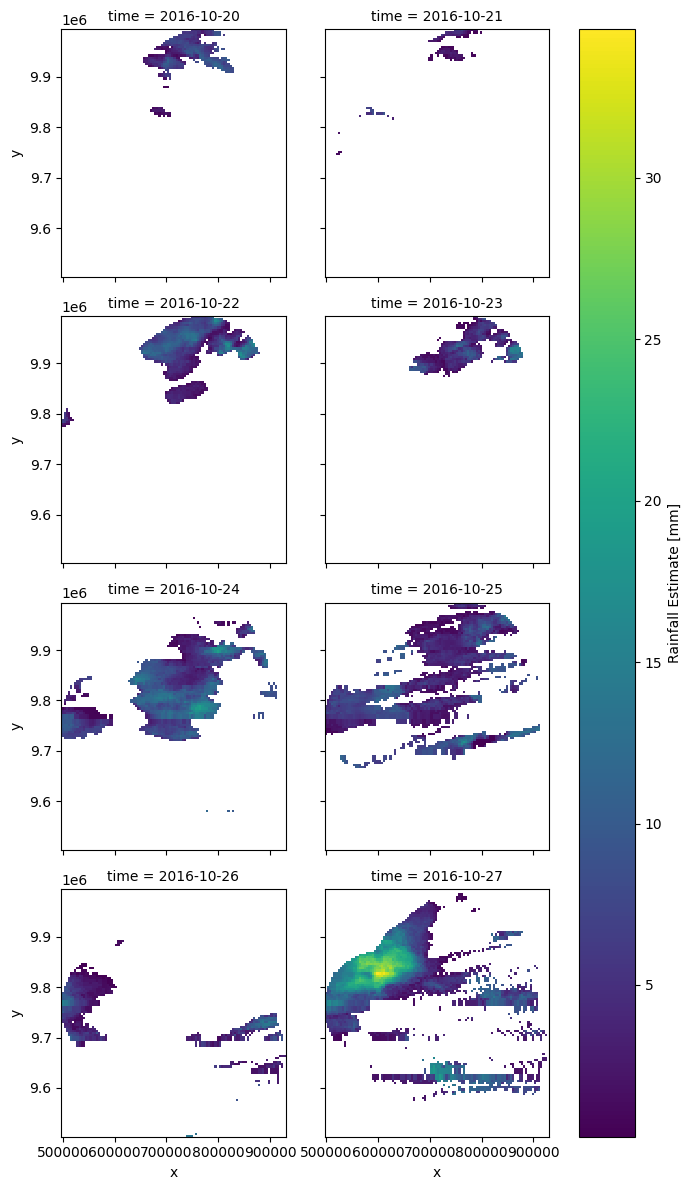

In [ ]:
## Plot the nearest cloud of different thresholds
from matplotlib.patches import FancyArrowPatch

#dfs = df['2013-11-20':'2013-11-27']
#df.set_index('date1', inplace=True)
dfd = df['2016-10-20':'2016-10-27']
dfd = dfd[dfd['ID'] == 'SW37']
#dfd.set_index('date1', inplace=True)
dm = ds_masked.sel(time=slice('2016-10-20', '2016-10-27'))
dm.plot(col='time', col_wrap=2 )
#dfcloud = df

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
#unique_ids = dfs['ID'].unique()
unique_ids = df['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        #gps_data_subset = dfs.loc[dfs.index == current_time]
        gps_data_subset = dfd.loc[dfd.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color=color, label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color=color, s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            ax.scatter(case_true_data['cloud_x'], case_true_data['cloud_y'], color='red', s=20)
            #ax.scatter(case_true_data['cloud_8mm_x'], case_true_data['cloud_8mm_y'], color='green', s=20)
            #ax.scatter(case_true_data['cloud_10mm_x'], case_true_data['cloud_10mm_y'], color='yellow', s=20)
            #ax.scatter(case_true_data['cloud4_x'], case_true_data['cloud4_y'], color='orange', s=20)
            #ax.scatter(case_true_data['cloud5_x'], case_true_data['cloud5_y'], color='brown', s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        # Set the x and y axis limits for zooming
        #ax.set_xlim(596742, 821598)
        #ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm
import multiprocessing
from functools import partial

def find_nearest_clouds(row, df2, threshold_mm):
    subset = df2[df2['date'] == row['date1']]
    
    if len(subset) == 0:
        return None  # Return None if there are no matching clouds
    
    distances = cdist(np.array([[row['x1_'], row['y1_']]]), subset[['x', 'y']], metric='euclidean')
    
    valid_clouds = []
    for i, distance in enumerate(distances[0]):
        if subset.iloc[i]['rfe'] > threshold_mm: #and distance <= max_distance_m:
            valid_clouds.append((i, distance))
    
    valid_clouds.sort(key=lambda x: x[1])
    
    if len(valid_clouds) > 0:
        cloud = subset.iloc[valid_clouds[0][0]]
        return cloud
    else:
        return None

def process_threshold(threshold_mm, df, df2):
    nearest_clouds = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing df1 (Threshold {threshold_mm})'):
        cloud = find_nearest_clouds(row, df2, threshold_mm=threshold_mm)
        if cloud is not None:
            nearest_clouds.append([cloud['x'], cloud['y'], cloud['rfe']])
        else:
            nearest_clouds.append([None, None, None])

    nearest_cloud_df = pd.DataFrame(nearest_clouds, columns=[f'cloud_{threshold_mm}mm_x', f'cloud_{threshold_mm}mm_y', f'cloud_{threshold_mm}mm_rfe'])
    
    return nearest_cloud_df

def calculate_turning_angles_for_threshold(args):
    index, row, threshold_mm = args  # Unpack the tuple to get the index, row, and threshold
    
    # Calculate vectors for trajectory and direction towards the cloud
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([row[f'cloud_{threshold_mm}mm_x'] - row['x1_'], row[f'cloud_{threshold_mm}mm_y'] - row['y1_']])
    
    # Calculate dot product and magnitudes
    dot_product = np.dot(trajectory_vector, cloud_vector) 
    magnitude_trajectory = np.linalg.norm(trajectory_vector)
    magnitude_cloud = np.linalg.norm(cloud_vector)
    
    # Calculate the angle in radians
    if magnitude_trajectory != 0 and magnitude_cloud != 0:
        cos_angle = dot_product / (magnitude_trajectory * magnitude_cloud)
        if cos_angle > 1:
            cos_angle = 1  # To handle potential rounding errors
        elif cos_angle < -1:
            cos_angle = -1  # To handle potential rounding errors
        cloud_angle_radians = np.arccos(cos_angle)
    else:
        cloud_angle_radians = 0  # Handle division by zero or zero-magnitude vectors
 
    cloud_angle_degrees = np.degrees(cloud_angle_radians)
    
    # Calculate difference in turning angles
   # ta_diff = row['ta_'] - turning_angle_cloud_radians
    #angle_difference = (ta_diff + np.pi) % (2 * np.pi) - np.pi

    return dot_product, magnitude_cloud, cloud_angle_radians, cloud_angle_degrees




Below code just calculates the turning angle calculations

In [ ]:
file = "data/Serengeti_data2.csv"
df = pd.read_csv(file, dtype=None)

df['time1'] = pd.to_datetime(df['t1_'])
df['date1'] = pd.to_datetime(df['time1'].dt.date)
df['time2'] = pd.to_datetime(df['t2_'])
df['date2'] = pd.to_datetime(df['time2'].dt.date)


df.set_index('date1', inplace=True)
df = df.sort_index()
df = df.reset_index()

df2 = rain#.reset_index()

In [ ]:
if __name__ == '__main__':
    thresholds = [5,10,15]
    num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
    # Split the DataFrame into chunks for parallel processing
    #chunk_size = len(df) #// num_processes
    #chunk_size = 200
    #chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    
    threshold_results = {}

    for threshold_mm in thresholds:
        with multiprocessing.Pool(processes=num_processes) as pool:
            args_list = [(index, row, threshold_mm) for index, row in df.iterrows()]
            turning_angle_results = list(tqdm(pool.map(calculate_turning_angles_for_threshold, args_list), total=len(df), desc=f'Calculating Turning Angles (Threshold {threshold_mm}mm)'))

        #direction_to_cloud_list, trajectory_vector_list, dot_product_list, magnitude_trajectory_list, magnitude_direction_to_cloud_list#, turning_angle_cloud_radians_list, turning_angle_cloud_degrees_list, angle_difference_list = zip(*turning_angle_results)
        dot_product_list, magnitude_cloud_list, cloud_angle_radians_list, cloud_angle_degrees_list = zip(*turning_angle_results)
        
        # Add the results to the original DataFrame with column names indicating the threshold
        df[f'dot_product_{threshold_mm}mm'] = dot_product_list
        df[f'magnitude_cloud_{threshold_mm}mm'] = magnitude_cloud_list
        df[f'cloud_angle_radians_{threshold_mm}mm'] = cloud_angle_radians_list
        df[f'cloud_angle_degrees_{threshold_mm}mm'] = cloud_angle_degrees_list

        threshold_results[threshold_mm] = {
            'dot_product': dot_product_list,
            'magnitude_cloud': magnitude_cloud_list,
            'cloud_angle_radians': cloud_angle_radians_list,
            'cloud_angle_degrees' : cloud_angle_degrees_list,
        }


    # You can access the results for each threshold from the `threshold_results` dictionary
    # Example: threshold_results[5]['turning_angle_cloud_degrees']


In [ ]:
df.head()

In [ ]:
df.to_csv('data/Serengeti2.csv', index=False)